# Libraries and Packages

In [3]:
# Uncomment for any libraries that are not installed

# %pip install transformers
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# %pip install numpy scipy scikit-learn pandas matplotlib
# %pip install imblearn
# %pip install nltk
# %pip install tqdm
# %pip install groq
# %pip install seaborn
# %pip install emoji
# %pip install sentencepiece
%pip install protobuf

Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup, pipeline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import time
import datetime
from tqdm import tqdm
import os

c:\Users\alexc\anaconda3\envs\TorchP11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset upload and CUDA switching

In [6]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Load the dataset
data_file = "train-balanced-sarcasm.csv"  # File must be in the same directory as this script
train_data = pd.read_csv(data_file)
train_data.head()

Using device: cuda


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


### Dataset Cleaning

In [7]:
# Dataset Cleaning

import os
import pandas as pd
import re
import emoji
from collections import Counter

df_file = os.path.join("train-balanced-sarcasm.csv")

# Cleaning text function
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = re.sub(r'http\S+', '', text)  # URL removal
    text = re.sub(r'@\w+', '', text)  # Mentions removal
    text = re.sub(r'#\w+', '', text)  # Hashtag removal
    text = re.sub(r'\d+', '', text)  # Number removal
    text = re.sub(r'[^\w\s]', '', text)  # Punctuation removal
    return text.lower().strip() # Lowercase and strip

# Verification valid text
def is_valid_text(text):
    # No emoji
    text = emoji.replace_emoji(text, '')
    # No extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # At least 3 words and 10 characters
    words = text.split()
    
    # No words reepated more than 5 times
    word_counts = Counter(words)
    if any(count > 5 for count in word_counts.values()):
        return False
    
    return len(words) >= 3 and len(text) > 10 and not text.isnumeric()

# Upload the dataset
print("Uploading dataset...")
df = pd.read_csv(df_file)
df = df[["label", "comment"]]

# Dataset cleaning
print("Cleaning dataset...")
df['cleaned_comment'] = df['comment'].apply(clean_text)
df['is_valid'] = df['cleaned_comment'].apply(is_valid_text)
df = df[df['is_valid']]
df = df.drop('is_valid', axis=1)
df['comment'] = df['comment'].astype(str)

# Sampling the dataset
sample = 200000
df = df.head(sample)

print("Dataset clean. New dataframe dimensions:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

Uploading dataset...
Cleaning dataset...
Dataset clean. New dataframe dimensions: (200000, 3)

First 5 rows:
   label                                            comment  \
1      0  You do know west teams play against west teams...   
2      0  They were underdogs earlier today, but since G...   
3      0  This meme isn't funny none of the "new york ni...   
4      0                    I could use one of those tools.   
5      0  I don't pay attention to her, but as long as s...   

                                     cleaned_comment  
1  you do know west teams play against west teams...  
2  they were underdogs earlier today but since gr...  
3  this meme isnt funny none of the new york nigg...  
4                     i could use one of those tools  
5  i dont pay attention to her but as long as she...  


## Dataset Exploration

QUI METTERE QUALCHE WORDCLOUD?

# Part 1 - Sarcasm detection

<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 800 500">
  <style>
    .small { font: italic 13px sans-serif; }
    .heavy { font: bold 30px sans-serif; }
    .caption { font: 16px sans-serif; }
  </style>
  
  <!-- Input Layer -->
  <rect x="50" y="50" width="150" height="75" fill="#FFB3BA" />
  <text x="125" y="80" text-anchor="middle" class="caption">Input Embeddings</text>
  <text x="125" y="100" text-anchor="middle" class="small">(MAX_LEN=256)</text>
  
  <!-- BERT Base Uncased -->
  <rect x="250" y="25" width="300" height="125" fill="#BAFFC9" />
  <text x="400" y="60" text-anchor="middle" class="heavy">BERT Base Uncased</text>
  <text x="400" y="90" text-anchor="middle" class="caption">Pre-trained on lower-cased</text>
  <text x="400" y="110" text-anchor="middle" class="caption">English text</text>
  
  <!-- Classification Layer -->
  <rect x="600" y="50" width="150" height="75" fill="#BAE1FF" />
  <text x="675" y="80" text-anchor="middle" class="caption">Classification Layer</text>
  <text x="675" y="100" text-anchor="middle" class="small">(2 classes)</text>
  
  <!-- Arrows -->
  <line x1="200" y1="75" x2="230" y2="75" stroke="black" stroke-width="2" marker-end="url(#arrowhead)"/>
  <line x1="550" y1="75" x2="580" y2="75" stroke="black" stroke-width="2" marker-end="url(#arrowhead)"/>
  
  <!-- Arrowhead definition -->
  <defs>
    <marker id="arrowhead" markerWidth="10" markerHeight="7" refX="0" refY="3.5" orient="auto">
      <polygon points="0 0, 10 3.5, 0 7" />
    </marker>
  </defs>
  
  <!-- Model Details -->
  <rect x="100" y="200" width="600" height="250" fill="#BAFFC9" stroke="#D3D3D3" stroke-width="2" />
  <text x="400" y="230" text-anchor="middle" class="caption">Model Details:</text>
  <text x="120" y="260" class="small">- BertForSequenceClassification</text>
  <text x="120" y="290" class="small">- Num labels: 2</text>
  <text x="120" y="320" class="small">- Optimizer: AdamW (lr=2e-5, eps=1e-8)</text>
  <text x="120" y="350" class="small">- Loss: CrossEntropyLoss</text>
  <text x="120" y="380" class="small">- Epochs: 5</text>
  <text x="120" y="410" class="small">- Batch size: 32</text>
  <text x="120" y="440" class="small">- Device: CUDA (if available)</text>
</svg>

### BERT

**General description**

We have used a BERT (Bidirectional Encoder Representations from Transformers) model, specifically the "*bert-base-uncased*" variant, fine-tuned for sequence classification.
Key characteristics of this model include:

- **Architecture**: It's based on the original BERT architecture, which consists of 12 transformer layers, 12 attention heads, and 768 hidden dimensions.

- **Pre-training**: This model was pre-trained on a large corpus of uncased English text (meaning it treats "The" and "the" as the same token). The pre-training tasks typically include masked language modeling and next sentence prediction, which help the model learn general language understanding.

- **Fine-tuning**: We've fine-tuned this pre-trained model for our specific task of sarcasm detection. This involves adding a classification layer on top of the BERT base and training on our sarcasm dataset.

- **Tokenizer**: It uses the BERT tokenizer, which employs WordPiece tokenization.

- **Sequence Classification**: The model is set up for sequence classification, where it takes in a sequence of tokens (in our case, a Reddit comment) and outputs a classification (sarcastic or not sarcastic).

- **Uncased**: As mentioned, this version is uncased, meaning it doesn't differentiate between uppercase and lowercase letters. This can be beneficial for tasks where case doesn't carry significant meaning, potentially reducing the vocabulary size and model complexity.

- **Size**: The "base" in "bert-base-uncased" indicates that this is the smaller version of BERT (as opposed to "bert-large"), with about 110 million parameters.

This model is well-suited for our task because it has been pre-trained on a large amount of text data, allowing it to capture complex language patterns that can be crucial for detecting sarcasm. The fine-tuning process then adapts this general language understanding to our specific task of sarcasm detection.


**Tokenization process**

The tokenization process in this project was performed using the BERT tokenizer, specifically the one associated with the 'bert-base-uncased' model. Here's a brief description of how it works:

*Tokenizer Initialization*:
The tokenizer is initialized using the BertTokenizer.from_pretrained('bert-base-uncased') method. This loads the pre-trained tokenizer that matches the BERT model we're using.
The 'uncased' version of the tokenizer converts all text to lowercase before tokenization. BERT uses WordPiece tokenization, which breaks words into subwords. This helps handle out-of-vocabulary words and reduces the overall vocabulary size. For example, "tokenization" might be broken into "token" and "##ization".

*Special Tokens*:
The tokenizer adds special tokens:

[CLS] at the beginning of each sequence (used for classification tasks)
[SEP] at the end of each sequence (or between sequences for pair tasks)

*Encoding*:
The tokenization process encodes each comment using the encode_plus method, which tokenizes the text, converts tokens to their respective IDs, adds special tokens, and generates attention masks (1 for real tokens, 0 for padding).

*Padding and Truncation*:
Sequences are padded to a maximum length (MAX_LEN = 128 in this case) with a padding token (usually [PAD]).
If a sequence is longer than MAX_LEN, it's truncated.

*Tensors Creation*:
The tokenized and encoded data is converted into PyTorch tensors for input to the model.

This process was applied to both the training and testing datasets, ensuring that the text input is in a format that the BERT model can process. The use of subword tokenization and special tokens allows the model to handle a wide variety of inputs, including words it hasn't seen during pre-training.

#### Preprocessing

In [12]:
num_examples = sample
comments = df[:num_examples].dropna().comment.values
labels = df[:num_examples].dropna().label.values

In [15]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

# Move the model to the appropriate device (CPU or GPU)
model.to(device)

# Tokenize and encode the dataset
MAX_LEN = 256

input_ids = []
attention_masks = []

for comment in comments:
    encoded_dict = tokenizer.encode_plus(
        comment,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

c:\Users\alexc\anaconda3\envs\TorchP11\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to

In [16]:
# Create DataLoader
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32

train_dataloader = DataLoader(
    train_dataset,
    sampler=torch.utils.data.RandomSampler(train_dataset),
    batch_size=batch_size
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=torch.utils.data.SequentialSampler(val_dataset),
    batch_size=batch_size
)

#### Optimization parameters

In [17]:
# Set up optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

c:\Users\alexc\anaconda3\envs\TorchP11\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#### Training

In [18]:
# Training loop for BERT model

def format_time(seconds):
    return str(datetime.timedelta(seconds=int(seconds)))

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Training loop
total_t0 = time.time()
total_train_loss = 0
total_val_loss = 0
total_val_accuracy = 0

for epoch in range(epochs):
    print(f'\nEpoch {epoch+1}/{epochs}')
    epoch_t0 = time.time()
    
    # Training
    model.train()
    total_train_loss = 0
    
    progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), 
                        desc="Training", unit="batch")
    
    for step, batch in progress_bar:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        # Update progress bar
        elapsed = format_time(time.time() - epoch_t0)
        elapsed_total = format_time(time.time() - total_t0)
        
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Epoch Elapsed': elapsed,
            'Total Elapsed': elapsed_total,
            'Epoch Remaining': format_time((time.time() - epoch_t0) / (step + 1) * (len(train_dataloader) - step - 1)),
            'Total Remaining': format_time((time.time() - total_t0) / ((epoch * len(train_dataloader) + step + 1)) * (epochs * len(train_dataloader) - (epoch * len(train_dataloader) + step + 1)))
        })

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        
        loss = outputs.loss
        logits = outputs.logits
        
        total_eval_loss += loss.item()
        total_eval_accuracy += flat_accuracy(logits.detach().cpu().numpy(), b_labels.to('cpu').numpy())

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Print epoch results
    print(f"\nEpoch {epoch+1} Results:")
    print(f"  Training Loss: {avg_train_loss:.4f}")
    print(f"  Validation Loss: {avg_val_loss:.4f}")
    print(f"  Validation Accuracy: {avg_val_accuracy:.4f}")
    print(f"  Epoch Time: {format_time(time.time() - epoch_t0)}")
    print(f"  Total Time: {format_time(time.time() - total_t0)}")

print("\nTraining complete!")
print(f"Total training took {format_time(time.time()-total_t0)}")


Epoch 1/5


Training:   0%|          | 0/5625 [00:00<?, ?batch/s]c:\Users\alexc\anaconda3\envs\TorchP11\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Training: 100%|██████████| 5625/5625 [24:57<00:00,  3.76batch/s, Loss=0.5295, Epoch Elapsed=0:24:57, Total Elapsed=0:24:57, Epoch Remaining=0:00:00, Total Remaining=1:39:51]



Epoch 1 Results:
  Training Loss: 0.5282
  Validation Loss: 0.4950
  Validation Accuracy: 0.7581
  Epoch Time: 0:25:49
  Total Time: 0:25:49

Epoch 2/5


Training: 100%|██████████| 5625/5625 [25:08<00:00,  3.73batch/s, Loss=0.3277, Epoch Elapsed=0:25:08, Total Elapsed=0:50:58, Epoch Remaining=0:00:00, Total Remaining=1:16:27]



Epoch 2 Results:
  Training Loss: 0.4300
  Validation Loss: 0.5165
  Validation Accuracy: 0.7575
  Epoch Time: 0:26:00
  Total Time: 0:51:50

Epoch 3/5


Training: 100%|██████████| 5625/5625 [27:30<00:00,  3.41batch/s, Loss=0.3738, Epoch Elapsed=0:27:30, Total Elapsed=1:19:20, Epoch Remaining=0:00:00, Total Remaining=0:52:53]



Epoch 3 Results:
  Training Loss: 0.3230
  Validation Loss: 0.5948
  Validation Accuracy: 0.7513
  Epoch Time: 0:28:28
  Total Time: 1:20:18

Epoch 4/5


Training: 100%|██████████| 5625/5625 [27:41<00:00,  3.38batch/s, Loss=0.1367, Epoch Elapsed=0:27:41, Total Elapsed=1:48:00, Epoch Remaining=0:00:00, Total Remaining=0:27:00]



Epoch 4 Results:
  Training Loss: 0.2286
  Validation Loss: 0.7345
  Validation Accuracy: 0.7426
  Epoch Time: 0:28:37
  Total Time: 1:48:56

Epoch 5/5


Training: 100%|██████████| 5625/5625 [27:40<00:00,  3.39batch/s, Loss=0.1978, Epoch Elapsed=0:27:40, Total Elapsed=2:16:37, Epoch Remaining=0:00:00, Total Remaining=0:00:00]



Epoch 5 Results:
  Training Loss: 0.1654
  Validation Loss: 0.8778
  Validation Accuracy: 0.7400
  Epoch Time: 0:28:38
  Total Time: 2:17:34

Training complete!
Total training took 2:17:34


In [19]:
# Save the entire model (including tokenizer)
output_dir = './bert_sarcasm_model3/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"Saving model to {output_dir}")
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print("Model and tokenizer saved!")

Saving model to ./bert_sarcasm_model3/
Model and tokenizer saved!


#### Deployment

In [20]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the saved model and tokenizer
model_path = './bert_sarcasm_model2/'
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def predict_sarcasm(text):
    # Tokenize and encode the text
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )
    
    input_ids = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)
    
    # Perform inference
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
    
    # Get prediction
    prediction = torch.argmax(logits, dim=1).item()
    probability = torch.nn.functional.softmax(logits, dim=1)[0][prediction].item()
    
    return "Sarcastic" if prediction == 1 else "Not sarcastic", probability

In [21]:
# Test the model with some example texts
example_texts = [
    "I absolutely love waiting in long lines at the DMV.",
    "The weather is beautiful today.",
    "Wow, getting a root canal is so much fun!",
    "I'm excited about the new movie coming out.",
    "This is the best day ever! My car broke down and I lost my wallet.",
    "Oh, great, another update that 'improves' the app by making it crash even more. Thanks, developers!",
    "Sure, because spending an entire day in line at the DMV is exactly how I wanted to spend my Saturday.",
    "Wow, this 50-page instruction manual for a simple coffee maker is exactly what I needed. So intuitive!",
    "Of course, I love when my internet cuts out right in the middle of a critical work meeting. Who doesn't?",
    "Yeah, because nothing says 'professionalism' like sending an email in Comic Sans.",
    "I think this new feature will be really useful for organizing my projects.",
    "Thanks for the suggestion! I'll definitely check out that book.",
    "I completely agree with you, the new season of the show is much better than the last one.",
    "That recipe turned out great! Thanks for sharing it with us.",
    "I had a great experience with their customer service, they were really helpful and responsive."
]

print("Predicting sarcasm for example texts:")
for text in example_texts:
    prediction, probability = predict_sarcasm(text)
    print(f"Text: {text}")
    print(f"Prediction: {prediction} (Probability: {probability:.2f})")
    print()

Predicting sarcasm for example texts:
Text: I absolutely love waiting in long lines at the DMV.
Prediction: Sarcastic (Probability: 0.77)

Text: The weather is beautiful today.
Prediction: Sarcastic (Probability: 0.73)

Text: Wow, getting a root canal is so much fun!
Prediction: Sarcastic (Probability: 0.98)

Text: I'm excited about the new movie coming out.
Prediction: Sarcastic (Probability: 0.95)

Text: This is the best day ever! My car broke down and I lost my wallet.
Prediction: Not sarcastic (Probability: 0.99)

Text: Oh, great, another update that 'improves' the app by making it crash even more. Thanks, developers!
Prediction: Sarcastic (Probability: 1.00)

Text: Sure, because spending an entire day in line at the DMV is exactly how I wanted to spend my Saturday.
Prediction: Sarcastic (Probability: 0.98)

Text: Wow, this 50-page instruction manual for a simple coffee maker is exactly what I needed. So intuitive!
Prediction: Sarcastic (Probability: 1.00)

Text: Of course, I love 

#### Evaluation

In [22]:
# Load and evaluate on test dataset
test_data = pd.read_csv("test_sarcasm.csv")

def prepare_data(data):
    input_ids = []
    attention_masks = []
    
    for comment in data['comment']:
        encoded_dict = tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=128,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    return input_ids, attention_masks

input_ids, attention_masks = prepare_data(test_data)
labels = torch.tensor(test_data['label'].values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\alexc\anaconda3\envs\TorchP11\Lib\site-packages\transformers\tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [23]:
# Create the DataLoader
test_dataset = TensorDataset(input_ids, attention_masks, labels)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Evaluation
predictions = []
true_labels = []

In [24]:
for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_attention_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_attention_mask)
    
    logits = outputs[0]
    batch_predictions = torch.argmax(logits, dim=1).flatten()
    
    predictions.extend(batch_predictions.cpu().numpy())
    true_labels.extend(b_labels.cpu().numpy())

In [25]:
# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')

print("Model Performance on Test Set:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Model Performance on Test Set:
Accuracy: 0.76
Precision: 0.77
Recall: 0.74
F1 Score: 0.76


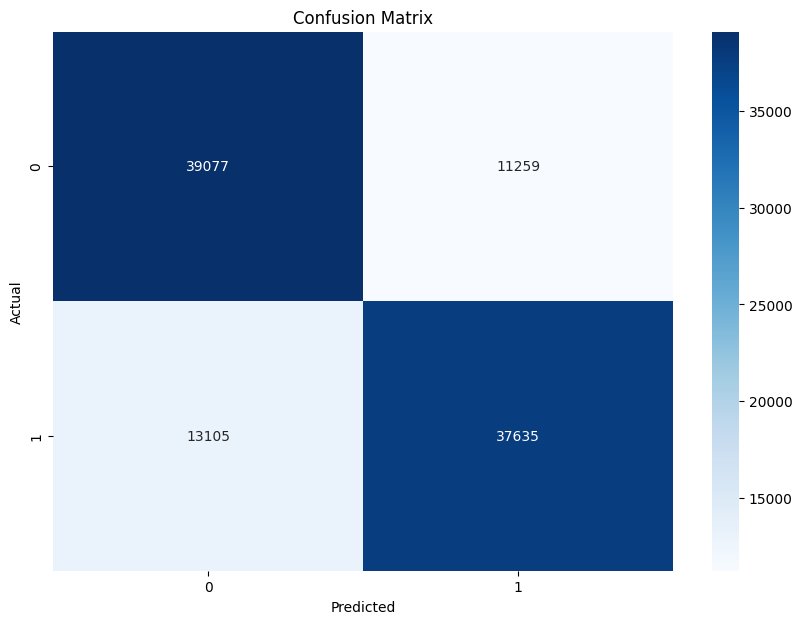

In [26]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

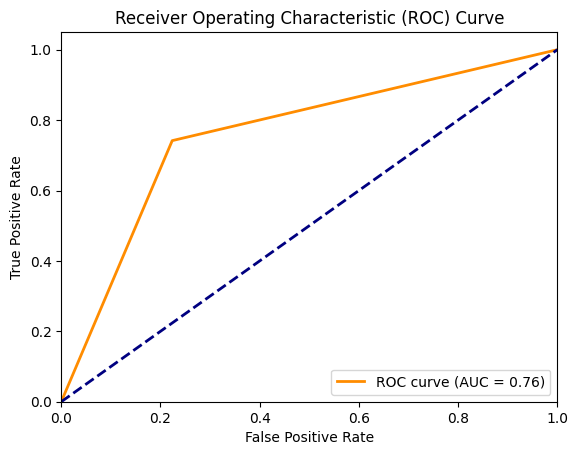

In [27]:
# ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### RoBERTa

<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 800 500">
  <style>
    .small { font: italic 13px sans-serif; }
    .heavy { font: bold 30px sans-serif; }
    .caption { font: 16px sans-serif; }
  </style>
  
  <!-- Input Layer -->
  <rect x="50" y="50" width="150" height="75" fill="#FFB3BA" />
  <text x="125" y="80" text-anchor="middle" class="caption">Input Embeddings</text>
  <text x="125" y="100" text-anchor="middle" class="small">(MAX_LEN=128)</text>
  
  <!-- RoBERTa Base -->
  <rect x="250" y="25" width="300" height="125" fill="#BAFFC9" />
  <text x="400" y="60" text-anchor="middle" class="heavy">RoBERTa Base</text>
  <text x="400" y="90" text-anchor="middle" class="caption">Pre-trained on</text>
  <text x="400" y="110" text-anchor="middle" class="caption">English text</text>
  
  <!-- Classification Layer -->
  <rect x="600" y="50" width="150" height="75" fill="#BAE1FF" />
  <text x="675" y="80" text-anchor="middle" class="caption">Classification Layer</text>
  <text x="675" y="100" text-anchor="middle" class="small">(2 classes)</text>
  
  <!-- Arrows -->
  <line x1="200" y1="75" x2="230" y2="75" stroke="black" stroke-width="2" marker-end="url(#arrowhead)"/>
  <line x1="550" y1="75" x2="580" y2="75" stroke="black" stroke-width="2" marker-end="url(#arrowhead)"/>
  
  <!-- Arrowhead definition -->
  <defs>
    <marker id="arrowhead" markerWidth="10" markerHeight="7" refX="0" refY="3.5" orient="auto">
      <polygon points="0 0, 10 3.5, 0 7" />
    </marker>
  </defs>
  
  <!-- Model Details -->
  <rect x="100" y="200" width="600" height="250" fill="#BAFFC9" stroke="#D3D3D3" stroke-width="2" />
  <text x="400" y="230" text-anchor="middle" class="caption">Model Details:</text>
  <text x="120" y="260" class="small">- RobertaForSequenceClassification</text>
  <text x="120" y="290" class="small">- Num labels: 2</text>
  <text x="120" y="320" class="small">- Optimizer: AdamW (lr=2e-5, eps=1e-8)</text>
  <text x="120" y="350" class="small">- Loss: CrossEntropyLoss</text>
  <text x="120" y="380" class="small">- Epochs: 5</text>
  <text x="120" y="410" class="small">- Batch size: 32</text>
  <text x="120" y="440" class="small">- Device: CUDA (if available)</text>
</svg>

**General description**

We have used a RoBERTa (A Robustly Optimized BERT Pretraining Approach) model, specifically the "*roberta-base*" variant, fine-tuned for sequence classification.
Key characteristics of this model include:

- **Architecture**: The RoBERTa model is based on the BERT architecture but with modifications in its pre-training approach. It consists of 12 transformer layers, 12 attention heads, and 768 hidden dimensions.

- **Pre-training**: This model was pre-trained on a significantly larger corpus compared to BERT, using dynamic masking and without the next sentence prediction task. The pre-training objective was masked language modeling, and RoBERTa was trained with larger batch sizes and learning rates, making it more robust in understanding language patterns.

- **Fine-tuning**: We've fine-tuned this pre-trained model for our specific task of sarcasm detection. A classification layer was added on top of the RoBERTa base model, and the model was trained on our sarcasm dataset.

- **Tokenizer**: It uses the RoBERTa tokenizer, which employs Byte-Pair Encoding (BPE) for tokenization.

- **Sequence Classification**: The model is configured for sequence classification, where it processes a sequence of tokens (e.g., a Reddit comment) and outputs a classification (sarcastic or not sarcastic).

- **Cased**: Unlike BERT's uncased variant, RoBERTa models are cased, meaning they differentiate between uppercase and lowercase letters. This can be beneficial for tasks where case sensitivity matters.

- **Size**: The "base" in "roberta-base" indicates that this is the smaller version of RoBERTa (as opposed to "roberta-large"), with about 125 million parameters.

This model is well-suited for our task because its robust pre-training allows it to capture complex language patterns that are crucial for detecting sarcasm. The fine-tuning process adapts this general language understanding to our specific task of sarcasm detection.

**Tokenization process**

The tokenization process in this project was performed using the RoBERTa tokenizer, specifically the one associated with the 'roberta-base' model. Here's a brief description of how it works:

*Tokenizer Initialization*:
The tokenizer is initialized using the `RobertaTokenizer.from_pretrained('roberta-base')` method. This loads the pre-trained tokenizer that matches the RoBERTa model we're using.
RoBERTa uses Byte-Pair Encoding (BPE) tokenization, which efficiently handles out-of-vocabulary words by breaking them into subwords. For example, "tokenization" might be split into "token" and "ization".

*Special Tokens*:
The tokenizer adds special tokens:

- **[CLS]**: RoBERTa does not use a [CLS] token. Instead, it relies on the first token of the sequence for classification tasks.
- **[SEP]**: Used at the end of each sequence or between sequences for pair tasks.

*Encoding*:
The tokenization process encodes each comment using the `encode_plus` method, which tokenizes the text, converts tokens to their respective IDs, adds special tokens, and generates attention masks (1 for real tokens, 0 for padding).

*Padding and Truncation*:
Sequences are padded to a maximum length (MAX_LEN = 128 in this case) with a padding token (usually [PAD]).
If a sequence is longer than MAX_LEN, it is truncated.

*Tensors Creation*:
The tokenized and encoded data is converted into PyTorch tensors for input to the model.

This process was applied to both the training and testing datasets, ensuring that the text input is in a format that the RoBERTa model can process. The use of Byte-Pair Encoding and special tokens allows the model to handle a wide variety of inputs, including words not encountered during pre-training.

#### Preprocessing

In [28]:
# Sampling
sample = 200000
train_data = train_data.head(sample)

print("Dataset cleaned. New dimensions:", train_data.shape)
print("\First 5 rows of cleaned dataframe:")
print(train_data.head())


comments = train_data.dropna().comment.values
labels = train_data.dropna().label.values

Dataset pulito e filtrato. Dimensioni del nuovo DataFrame: (200000, 10)

Prime 5 righe del DataFrame pulito:
   label                                            comment     author  \
0      0                                         NC and NH.  Trumpbart   
1      0  You do know west teams play against west teams...  Shbshb906   
2      0  They were underdogs earlier today, but since G...   Creepeth   
3      0  This meme isn't funny none of the "new york ni...  icebrotha   
4      0                    I could use one of those tools.  cush2push   

            subreddit  score  ups  downs     date          created_utc  \
0            politics      2   -1     -1  2016-10  2016-10-16 23:55:23   
1                 nba     -4   -1     -1  2016-11  2016-11-01 00:24:10   
2                 nfl      3    3      0  2016-09  2016-09-22 21:45:37   
3  BlackPeopleTwitter     -8   -1     -1  2016-10  2016-10-18 21:03:47   
4  MaddenUltimateTeam      6   -1     -1  2016-12  2016-12-30 17:00:13   

 

In [29]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Initialize RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base')

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Tokenize and encode the dataset
MAX_LEN = 128
BATCH_SIZE = 32  # Adjust batch size as needed for your hardware

# Assuming `comments` is your list of comments and `labels` is your list of labels
input_ids = []
attention_masks = []

# Use tqdm for a progress bar during tokenization
for comment in tqdm(comments, desc="Tokenizing"):
    encoded_dict = tokenizer.encode_plus(
        comment,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert lists to tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

c:\Users\alexc\anaconda3\envs\TorchP11\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Tokenizing: 100%|██████████| 199995/199995 [00:22<00:00, 8795.84it/s] 


In [ ]:
# Create DataLoader
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32

train_dataloader = DataLoader(
    train_dataset,
    sampler=torch.utils.data.RandomSampler(train_dataset),
    batch_size=batch_size
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=torch.utils.data.SequentialSampler(val_dataset),
    batch_size=batch_size
)

In [ ]:
# Load pre-trained BERT model
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

model.to(device)

#### Optimization

In [ ]:
# Set up optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

#### Training

In [21]:
# Training loop RoBERTa

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round(elapsed))))

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

total_t0 = time.time()

for epoch_i in range(0, epochs):
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print(f'  Batch {step}  of  {len(train_dataloader)}.    Elapsed: {elapsed}.')

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print(f"  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training epoch took: {training_time}")
        
    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels)
            
        loss = outputs.loss
        logits = outputs.logits
        
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print(f"  Accuracy: {avg_val_accuracy:.2f}")

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)
    
    print(f"  Validation Loss: {avg_val_loss:.2f}")
    print(f"  Validation took: {validation_time}")

print("")
print("Training complete!")
print(f"Total training took {format_time(time.time()-total_t0)}")

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]


======== Epoch 1 / 5 ========
Training...



  Average training loss: 0.55
  Training epoch took: 0:06:59

Running Validation...


Epochs:  20%|██        | 1/5 [07:12<28:51, 432.76s/it]

  Accuracy: 0.76
  Validation Loss: 0.51
  Validation took: 0:00:13

======== Epoch 2 / 5 ========
Training...



  Average training loss: 0.47
  Training epoch took: 0:06:58

Running Validation...


Epochs:  40%|████      | 2/5 [14:24<21:36, 432.18s/it]

  Accuracy: 0.76
  Validation Loss: 0.50
  Validation took: 0:00:13

======== Epoch 3 / 5 ========
Training...



  Average training loss: 0.40
  Training epoch took: 0:07:00

Running Validation...


Epochs:  60%|██████    | 3/5 [21:37<14:25, 432.62s/it]

  Accuracy: 0.76
  Validation Loss: 0.55
  Validation took: 0:00:13

======== Epoch 4 / 5 ========
Training...



  Average training loss: 0.33
  Training epoch took: 0:07:07

Running Validation...


Epochs:  80%|████████  | 4/5 [28:58<07:15, 435.70s/it]

  Accuracy: 0.76
  Validation Loss: 0.59
  Validation took: 0:00:14

======== Epoch 5 / 5 ========
Training...



  Average training loss: 0.28
  Training epoch took: 0:07:05

Running Validation...


Epochs: 100%|██████████| 5/5 [36:16<00:00, 435.39s/it]

  Accuracy: 0.76
  Validation Loss: 0.66
  Validation took: 0:00:14

Training complete!
Total training took 0:36:17


In [22]:
# Save the entire model (including tokenizer)
output_dir = './roberta_sarcasm_model/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"Saving model to {output_dir}")
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print("Model and tokenizer saved!")

Saving model to ./roberta_sarcasm_model/
Model and tokenizer saved!


#### Deployment

In [24]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the saved model and tokenizer
model_path = r"C:\Users\andre\OneDrive\Desktop\Modelli NLP\roberta_sarcasm_model2"
model = RobertaForSequenceClassification.from_pretrained(model_path)
tokenizer = RobertaTokenizer.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def predict_sarcasm(text):
    # Tokenize and encode the text
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )
    
    input_ids = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)
    
    # Perform inference
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
    
    # Get prediction
    prediction = torch.argmax(logits, dim=1).item()
    probability = torch.nn.functional.softmax(logits, dim=1)[0][prediction].item()
    
    return "Sarcastic" if prediction == 1 else "Not sarcastic", probability

In [25]:
# Test the model with some example texts
example_texts = [
    "I absolutely love waiting in long lines at the DMV.",
    "The weather is beautiful today.",
    "Wow, getting a root canal is so much fun!",
    "I'm excited about the new movie coming out.",
    "This is the best day ever! My car broke down and I lost my wallet.",
    "Oh, great, another update that 'improves' the app by making it crash even more. Thanks, developers!",
    "Sure, because spending an entire day in line at the DMV is exactly how I wanted to spend my Saturday.",
    "Wow, this 50-page instruction manual for a simple coffee maker is exactly what I needed. So intuitive!",
    "Of course, I love when my internet cuts out right in the middle of a critical work meeting. Who doesn't?",
    "Yeah, because nothing says 'professionalism' like sending an email in Comic Sans.",
    "I think this new feature will be really useful for organizing my projects.",
    "Thanks for the suggestion! I'll definitely check out that book.",
    "I completely agree with you, the new season of the show is much better than the last one.",
    "That recipe turned out great! Thanks for sharing it with us.",
    "I had a great experience with their customer service, they were really helpful and responsive."
]

print("Predicting sarcasm for example texts:")
for text in example_texts:
    prediction, probability = predict_sarcasm(text)
    print(f"Text: {text}")
    print(f"Prediction: {prediction} (Probability: {probability:.2f})")
    print()

Testing individual texts:
Text: I absolutely love waiting in long lines at the DMV.
Prediction: Sarcastic
Confidence: 0.99

Text: The weather is beautiful today.
Prediction: Not sarcastic
Confidence: 0.77

Text: Wow, getting a root canal is my favorite way to spend an afternoon!
Prediction: Sarcastic
Confidence: 0.91

Text: I'm excited about the new movie coming out next week.
Prediction: Sarcastic
Confidence: 0.98



#### Evaluation

In [26]:
# Load and evaluate on test dataset
test_data = pd.read_csv("test_sarcasm.csv")

def prepare_data(data):
    input_ids = []
    attention_masks = []
    
    for comment in data['comment']:
        encoded_dict = tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=128,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    return input_ids, attention_masks

input_ids, attention_masks = prepare_data(test_data)
labels = torch.tensor(test_data['label'].values)

# Create the DataLoader
test_dataset = TensorDataset(input_ids, attention_masks, labels)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Evaluation
predictions = []
true_labels = []
prediction_probs = []

for batch in tqdm(test_dataloader, desc="Evaluating"):
    b_input_ids = batch[0].to(device)
    b_attention_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_attention_mask)
    
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    batch_predictions = torch.argmax(probabilities, dim=1).flatten()
    
    predictions.extend(batch_predictions.cpu().numpy())
    true_labels.extend(b_labels.cpu().numpy())
    prediction_probs.extend(probabilities[:, 1].cpu().numpy())

Evaluating on test dataset...


Evaluating: 100%|██████████| 3159/3159 [02:16<00:00, 23.12it/s]


In [27]:
# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')

print("Model Performance on Test Set:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Model Performance on Test Set:
Accuracy: 0.77
Precision: 0.79
Recall: 0.73
F1 Score: 0.76


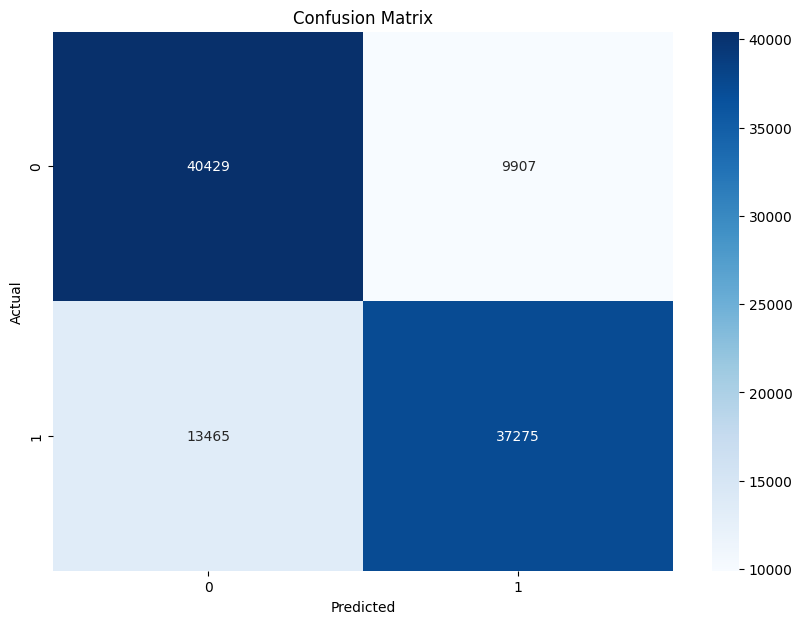

In [28]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

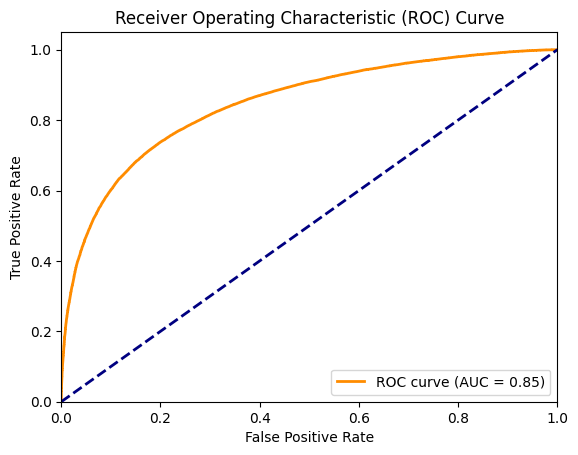

In [29]:
# ROC Curve
fpr, tpr, _ = roc_curve(true_labels, prediction_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#Configurazione GPU/CPU

### AlBERT

<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 800 500">
  <style>
    .small { font: italic 13px sans-serif; }
    .heavy { font: bold 30px sans-serif; }
    .caption { font: 16px sans-serif; }
  </style>
  
  <!-- Input Layer -->
  <rect x="50" y="50" width="150" height="75" fill="#FFB3BA" />
  <text x="125" y="80" text-anchor="middle" class="caption">Input Embeddings</text>
  <text x="125" y="100" text-anchor="middle" class="small">(MAX_LEN=128)</text>
  
  <!-- ALBERT Base v2 -->
  <rect x="240" y="25" width="320" height="125" fill="#BAFFC9" />
  <text x="400" y="60" text-anchor="middle" class="heavy">ALBERT Base v2</text>
  <text x="400" y="90" text-anchor="middle" class="caption">Pre-trained on English text</text>
  <text x="400" y="110" text-anchor="middle" class="caption">Parameter sharing &amp; factorized embedding</text>
  
  <!-- Classification Layer -->
  <rect x="600" y="50" width="150" height="75" fill="#BAE1FF" />
  <text x="675" y="80" text-anchor="middle" class="caption">Classification Layer</text>
  <text x="675" y="100" text-anchor="middle" class="small">(2 classes)</text>
  
  <!-- Arrows -->
  <line x1="200" y1="75" x2="220" y2="75" stroke="black" stroke-width="2" marker-end="url(#arrowhead)"/>
  <line x1="560" y1="75" x2="580" y2="75" stroke="black" stroke-width="2" marker-end="url(#arrowhead)"/>
  
  <!-- Arrowhead definition -->
  <defs>
    <marker id="arrowhead" markerWidth="10" markerHeight="7" refX="0" refY="3.5" orient="auto">
      <polygon points="0 0, 10 3.5, 0 7" />
    </marker>
  </defs>
  
  <!-- Model Details -->
  <rect x="100" y="200" width="600" height="250" fill="#BAFFC9" stroke="#D3D3D3" stroke-width="2" />
  <text x="400" y="230" text-anchor="middle" class="caption">Model Details:</text>
  <text x="120" y="260" class="small">- AlbertForSequenceClassification</text>
  <text x="120" y="290" class="small">- Num labels: 2</text>
  <text x="120" y="320" class="small">- Optimizer: AdamW (lr=2e-5, eps=1e-8)</text>
  <text x="120" y="350" class="small">- Loss: CrossEntropyLoss</text>
  <text x="120" y="380" class="small">- Epochs: 5</text>
  <text x="120" y="410" class="small">- Batch size: 32</text>
  <text x="120" y="440" class="small">- Device: CUDA (if available)</text>
</svg>

#### Preprocessing

In [8]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import AlbertTokenizer, AlbertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
import numpy as np
from tqdm import tqdm
import time
import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc

# Initialize ALBERT tokenizer
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

# Load pre-trained ALBERT model
model = AlbertForSequenceClassification.from_pretrained(
    "albert-base-v2",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

# Move the model to the appropriate device (CPU or GPU)
model.to(device)

# Tokenize and encode the dataset
MAX_LEN = 256

def encode_comments(comments):
    input_ids = []
    attention_masks = []

    for comment in comments:
        encoded_dict = tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

input_ids, attention_masks = encode_comments(df['comment'].values)
labels = torch.tensor(df['label'].values)

c:\Users\alexc\anaconda3\envs\TorchP11\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\alexc\.cache\huggingface\hub\models--albert-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
c:\Users\alexc\anaconda3\envs\TorchP11\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWar

In [9]:
# Create DataLoader
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32

train_dataloader = DataLoader(
    train_dataset,
    sampler=torch.utils.data.RandomSampler(train_dataset),
    batch_size=batch_size
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=torch.utils.data.SequentialSampler(val_dataset),
    batch_size=batch_size
)

#### Optimization

In [10]:
# Set up optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

# Helper functions
def format_time(seconds):
    return str(datetime.timedelta(seconds=int(seconds)))

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

c:\Users\alexc\anaconda3\envs\TorchP11\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#### Training

In [11]:
# Training loop
total_t0 = time.time()

for epoch in range(epochs):
    print(f'\nEpoch {epoch+1}/{epochs}')
    epoch_t0 = time.time()
    
    # Training
    model.train()
    total_train_loss = 0
    
    progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), 
                        desc="Training", unit="batch")
    
    for step, batch in progress_bar:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        # Update progress bar
        elapsed = format_time(time.time() - epoch_t0)
        elapsed_total = format_time(time.time() - total_t0)
        
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Epoch Elapsed': elapsed,
            'Total Elapsed': elapsed_total,
            'Epoch Remaining': format_time((time.time() - epoch_t0) / (step + 1) * (len(train_dataloader) - step - 1)),
            'Total Remaining': format_time((time.time() - total_t0) / ((epoch * len(train_dataloader) + step + 1)) * (epochs * len(train_dataloader) - (epoch * len(train_dataloader) + step + 1)))
        })

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        
        loss = outputs.loss
        logits = outputs.logits
        
        total_eval_loss += loss.item()
        total_eval_accuracy += flat_accuracy(logits.detach().cpu().numpy(), b_labels.to('cpu').numpy())

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Print epoch results
    print(f"\nEpoch {epoch+1} Results:")
    print(f"  Training Loss: {avg_train_loss:.4f}")
    print(f"  Validation Loss: {avg_val_loss:.4f}")
    print(f"  Validation Accuracy: {avg_val_accuracy:.4f}")
    print(f"  Epoch Time: {format_time(time.time() - epoch_t0)}")
    print(f"  Total Time: {format_time(time.time() - total_t0)}")

print("\nTraining complete!")
print(f"Total training took {format_time(time.time()-total_t0)}")


Epoch 1/5


Training: 100%|██████████| 5625/5625 [36:56<00:00,  2.54batch/s, Loss=0.5002, Epoch Elapsed=0:36:56, Total Elapsed=0:36:56, Epoch Remaining=0:00:00, Total Remaining=2:27:45]



Epoch 1 Results:
  Training Loss: 0.5583
  Validation Loss: 0.5259
  Validation Accuracy: 0.7355
  Epoch Time: 0:38:32
  Total Time: 0:38:32

Epoch 2/5


Training: 100%|██████████| 5625/5625 [36:50<00:00,  2.54batch/s, Loss=0.6752, Epoch Elapsed=0:36:50, Total Elapsed=1:15:23, Epoch Remaining=0:00:00, Total Remaining=1:53:05]



Epoch 2 Results:
  Training Loss: 0.4877
  Validation Loss: 0.5064
  Validation Accuracy: 0.7493
  Epoch Time: 0:38:23
  Total Time: 1:16:55

Epoch 3/5


Training: 100%|██████████| 5625/5625 [36:37<00:00,  2.56batch/s, Loss=0.3383, Epoch Elapsed=0:36:37, Total Elapsed=1:53:33, Epoch Remaining=0:00:00, Total Remaining=1:15:42]



Epoch 3 Results:
  Training Loss: 0.4172
  Validation Loss: 0.5261
  Validation Accuracy: 0.7495
  Epoch Time: 0:38:09
  Total Time: 1:55:05

Epoch 4/5


Training: 100%|██████████| 5625/5625 [37:06<00:00,  2.53batch/s, Loss=0.1919, Epoch Elapsed=0:37:06, Total Elapsed=2:32:12, Epoch Remaining=0:00:00, Total Remaining=0:38:03]



Epoch 4 Results:
  Training Loss: 0.3141
  Validation Loss: 0.6256
  Validation Accuracy: 0.7421
  Epoch Time: 0:38:40
  Total Time: 2:33:45

Epoch 5/5


Training: 100%|██████████| 5625/5625 [36:41<00:00,  2.55batch/s, Loss=0.1660, Epoch Elapsed=0:36:41, Total Elapsed=3:10:27, Epoch Remaining=0:00:00, Total Remaining=0:00:00]



Epoch 5 Results:
  Training Loss: 0.1947
  Validation Loss: 0.8019
  Validation Accuracy: 0.7350
  Epoch Time: 0:38:14
  Total Time: 3:12:00

Training complete!
Total training took 3:12:00


In [12]:
# Save the entire model (including tokenizer)
output_dir = './albert_sarcasm_model/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"Saving model to {output_dir}")
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print("Model and tokenizer saved!")

Saving model to ./albert_sarcasm_model/
Model and tokenizer saved!


#### Deployment

In [13]:
# Function to predict sarcasm
def predict_sarcasm(text):
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )
    
    input_ids = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
    
    prediction = torch.argmax(logits, dim=1).item()
    probability = torch.nn.functional.softmax(logits, dim=1)[0][prediction].item()
    
    return "Sarcastic" if prediction == 1 else "Not sarcastic", probability

#### Evaluation

In [14]:
# Test the model with some example texts
example_texts = [
    "I absolutely love waiting in long lines at the DMV.",
    "The weather is beautiful today.",
    "Wow, getting a root canal is so much fun!",
    "I'm excited about the new movie coming out.",
    "This is the best day ever! My car broke down and I lost my wallet.",
]

print("Predicting sarcasm for example texts:")
for text in example_texts:
    prediction, probability = predict_sarcasm(text)
    print(f"Text: {text}")
    print(f"Prediction: {prediction} (Probability: {probability:.2f})")
    print()

Predicting sarcasm for example texts:
Text: I absolutely love waiting in long lines at the DMV.
Prediction: Not sarcastic (Probability: 0.81)

Text: The weather is beautiful today.
Prediction: Not sarcastic (Probability: 0.99)

Text: Wow, getting a root canal is so much fun!
Prediction: Sarcastic (Probability: 1.00)

Text: I'm excited about the new movie coming out.
Prediction: Not sarcastic (Probability: 0.79)

Text: This is the best day ever! My car broke down and I lost my wallet.
Prediction: Not sarcastic (Probability: 0.68)



In [15]:
# Evaluation on test dataset
def prepare_data(data):
    input_ids, attention_masks = encode_comments(data['comment'])
    return input_ids, attention_masks

# Assuming you have a test_data DataFrame
test_data = pd.read_csv("test_sarcasm.csv")  # Make sure to replace with your actual test data file
input_ids, attention_masks = prepare_data(test_data)
labels = torch.tensor(test_data['label'].values)

# Create the DataLoader
test_dataset = TensorDataset(input_ids, attention_masks, labels)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Evaluation
predictions = []
true_labels = []

for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_attention_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_attention_mask)
    
    logits = outputs.logits
    batch_predictions = torch.argmax(logits, dim=1).flatten()
    
    predictions.extend(batch_predictions.cpu().numpy())
    true_labels.extend(b_labels.cpu().numpy())

In [16]:
# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')

print("Model Performance on Test Set:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Model Performance on Test Set:
Accuracy: 0.77
Precision: 0.80
Recall: 0.73
F1 Score: 0.76


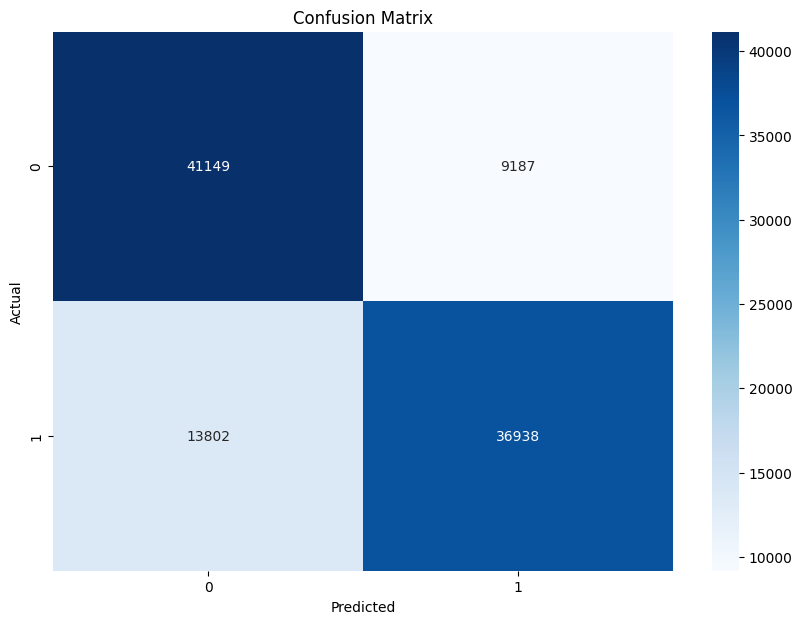

In [17]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

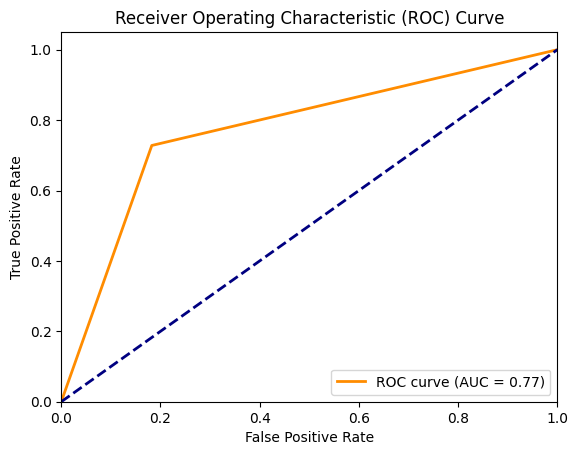

In [18]:
# ROC Curve
fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### DistilBERT

<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 800 500">
  <style>
    .small { font: italic 13px sans-serif; }
    .heavy { font: bold 30px sans-serif; }
    .caption { font: 16px sans-serif; }
  </style>
  
  <!-- Input Layer -->
  <rect x="50" y="50" width="150" height="75" fill="#FFB3BA" />
  <text x="125" y="80" text-anchor="middle" class="caption">Input Embeddings</text>
  <text x="125" y="100" text-anchor="middle" class="small">(MAX_LEN=128)</text>
  
  <!-- DistilBERT Base Uncased -->
  <rect x="250" y="25" width="300" height="125" fill="#BAFFC9" />
  <text x="400" y="60" text-anchor="middle" class="heavy">DistilBERT Uncased</text>
  <text x="400" y="90" text-anchor="middle" class="caption">Pre-trained on lower-cased</text>
  <text x="400" y="110" text-anchor="middle" class="caption">English text</text>
  
  <!-- Classification Layer -->
  <rect x="600" y="50" width="150" height="75" fill="#BAE1FF" />
  <text x="675" y="80" text-anchor="middle" class="caption">Classification Layer</text>
  <text x="675" y="100" text-anchor="middle" class="small">(2 classes)</text>
  
  <!-- Arrows -->
  <line x1="200" y1="75" x2="230" y2="75" stroke="black" stroke-width="2" marker-end="url(#arrowhead)"/>
  <line x1="550" y1="75" x2="580" y2="75" stroke="black" stroke-width="2" marker-end="url(#arrowhead)"/>
  
  <!-- Arrowhead definition -->
  <defs>
    <marker id="arrowhead" markerWidth="10" markerHeight="7" refX="0" refY="3.5" orient="auto">
      <polygon points="0 0, 10 3.5, 0 7" />
    </marker>
  </defs>
  
  <!-- Model Details -->
  <rect x="100" y="200" width="600" height="250" fill="#BAFFC9" stroke="#D3D3D3" stroke-width="2" />
  <text x="400" y="230" text-anchor="middle" class="caption">Model Details:</text>
  <text x="120" y="260" class="small">- DistilBertForSequenceClassification</text>
  <text x="120" y="290" class="small">- Num labels: 2</text>
  <text x="120" y="320" class="small">- Optimizer: AdamW (lr=2e-5, eps=1e-8)</text>
  <text x="120" y="350" class="small">- Loss: CrossEntropyLoss</text>
  <text x="120" y="380" class="small">- Epochs: 5</text>
  <text x="120" y="410" class="small">- Batch size: 32</text>
  <text x="120" y="440" class="small">- Device: CUDA (if available)</text>
</svg>

**General description**

We have used a DistilBERT (Distilled version of BERT) model, specifically the "*distilbert-base-uncased*" variant, fine-tuned for sequence classification.
Key characteristics of this model include:

- **Architecture**: DistilBERT is a smaller, faster, and lighter version of BERT. It retains 6 transformer layers, 12 attention heads, and 768 hidden dimensions. This is achieved through a process called knowledge distillation, where a smaller model (DistilBERT) is trained to replicate the performance of a larger model (BERT).

- **Pre-training**: This model was pre-trained on a large corpus of uncased English text (meaning it treats "The" and "the" as the same token). DistilBERT was trained using the same masked language modeling task as BERT but without the next sentence prediction task. The distillation process compresses the knowledge from BERT into a smaller model, maintaining about 97% of BERT's performance while being 60% faster and 40% smaller.

- **Fine-tuning**: We've fine-tuned this pre-trained model for our specific task of sarcasm detection. This involves adding a classification layer on top of the DistilBERT base and training on our sarcasm dataset.

- **Tokenizer**: It uses the DistilBERT tokenizer, which employs WordPiece tokenization, identical to that used by BERT.

- **Sequence Classification**: The model is set up for sequence classification, where it processes a sequence of tokens (e.g., a Reddit comment) and outputs a classification (sarcastic or not sarcastic).

- **Uncased**: As mentioned, this version is uncased, meaning it doesn't differentiate between uppercase and lowercase letters. This can be beneficial for tasks where case doesn't carry significant meaning, potentially reducing the vocabulary size and model complexity.

- **Size**: The "base" in "distilbert-base-uncased" indicates that this is the smaller version of DistilBERT, with about 66 million parameters, making it significantly more efficient in terms of memory and computational cost compared to BERT.

This model is well-suited for our task because it balances performance and efficiency, capturing complex language patterns essential for detecting sarcasm while being faster and lighter than the full BERT model. The fine-tuning process adapts this general language understanding to our specific task of sarcasm detection.

**Tokenization process**

The tokenization process in this project was performed using the DistilBERT tokenizer, specifically the one associated with the 'distilbert-base-uncased' model. Here's a brief description of how it works:

*Tokenizer Initialization*:
The tokenizer is initialized using the `DistilBertTokenizer.from_pretrained('distilbert-base-uncased')` method. This loads the pre-trained tokenizer that matches the DistilBERT model we're using.
The 'uncased' version of the tokenizer converts all text to lowercase before tokenization. DistilBERT uses WordPiece tokenization, which breaks words into subwords. This helps handle out-of-vocabulary words and reduces the overall vocabulary size. For example, "tokenization" might be broken into "token" and "##ization".

*Special Tokens*:
The tokenizer adds special tokens:

- **[CLS]**: DistilBERT uses a [CLS] token at the beginning of each sequence, which is used for classification tasks.
- **[SEP]**: Used at the end of each sequence (or between sequences for pair tasks).

*Encoding*:
The tokenization process encodes each comment using the `encode_plus` method, which tokenizes the text, converts tokens to their respective IDs, adds special tokens, and generates attention masks (1 for real tokens, 0 for padding).

*Padding and Truncation*:
Sequences are padded to a maximum length (MAX_LEN = 128 in this case) with a padding token (usually [PAD]).
If a sequence is longer than MAX_LEN, it is truncated.

*Tensors Creation*:
The tokenized and encoded data is converted into PyTorch tensors for input to the model.

This process was applied to both the training and testing datasets, ensuring that the text input is in a format that the DistilBERT model can process. The use of subword tokenization and special tokens allows the model to handle a wide variety of inputs, including words it hasn't seen during pre-training.

#### Preprocessing

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW

# Initialize DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

# Load pre-trained DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

model.to(device)

In [ ]:
# Tokenize and encode the dataset
MAX_LEN = 128

input_ids = []
attention_masks = []

# Use tqdm for a progress bar during tokenization
for comment in tqdm(comments, desc="Tokenizing"):
    encoded_dict = tokenizer.encode_plus(
        comment,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert lists to tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Move tensors to the appropriate device
input_ids = input_ids.to(device)
attention_masks = attention_masks.to(device)
labels = labels.to(device)

In [ ]:
# Create DataLoader
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32

train_dataloader = DataLoader(
    train_dataset,
    sampler=torch.utils.data.RandomSampler(train_dataset),
    batch_size=batch_size
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=torch.utils.data.SequentialSampler(val_dataset),
    batch_size=batch_size
)

In [ ]:
# Load pre-trained DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

model.to(device)

#### Optimization

In [ ]:
# Set up optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

#### Training

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round(elapsed))))

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

total_t0 = time.time()

for epoch_i in range(0, epochs):
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    # Aggiunta di tqdm per la barra di progresso durante il training
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print(f'  Batch {step}  of  {len(train_dataloader)}.    Elapsed: {elapsed}.')

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids,  
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print(f"\n  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training epoch took: {training_time}")
        
    print("\nRunning Validation...")

    t0 = time.time()
    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0

    # Aggiunta di tqdm per la barra di progresso durante la validazione
    for batch in tqdm(validation_dataloader, desc="Validation"):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            outputs = model(b_input_ids, 
                            attention_mask=b_input_mask,
                            labels=b_labels)
            
        loss = outputs.loss
        logits = outputs.logits
        
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print(f"  Accuracy: {avg_val_accuracy:.2f}")

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)
    
    print(f"  Validation Loss: {avg_val_loss:.2f}")
    print(f"  Validation took: {validation_time}")

print("")
print("Training complete!")
print(f"Total training took {format_time(time.time()-total_t0)}")

In [ ]:
# Specify query directory
output_dir = os.path.expanduser('./distilbert_sarcasm_model2/')

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"Saving model to {output_dir}")

# Save the model
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)

# Save the tokenizer
tokenizer.save_pretrained(output_dir)

print("Model and tokenizer saved!")

#### Deployment

In [ ]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the saved model and tokenizer

model_path = './distilbert_sarcasm_model2/'
model = DistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer = DistilBertTokenizer.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def predict_sarcasm(text):
    # Tokenize and encode the text
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )
    
    input_ids = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)
    
    # Perform inference
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
    
    # Get prediction
    prediction = torch.argmax(logits, dim=1).item()
    probability = torch.nn.functional.softmax(logits, dim=1)[0][prediction].item()
    
    return "Sarcastic" if prediction == 1 else "Not sarcastic", probability

In [ ]:
# Test the model with some example texts
example_texts = [
    "I absolutely love waiting in long lines at the DMV.",
    "The weather is beautiful today.",
    "Wow, getting a root canal is so much fun!",
    "I'm excited about the new movie coming out.",
    "This is the best day ever! My car broke down and I lost my wallet.",
    "Oh, great, another update that 'improves' the app by making it crash even more. Thanks, developers!",
    "Sure, because spending an entire day in line at the DMV is exactly how I wanted to spend my Saturday.",
    "Wow, this 50-page instruction manual for a simple coffee maker is exactly what I needed. So intuitive!",
    "Of course, I love when my internet cuts out right in the middle of a critical work meeting. Who doesn't?",
    "Yeah, because nothing says 'professionalism' like sending an email in Comic Sans.",
    "I think this new feature will be really useful for organizing my projects.",
    "Thanks for the suggestion! I'll definitely check out that book.",
    "I completely agree with you, the new season of the show is much better than the last one.",
    "That recipe turned out great! Thanks for sharing it with us.",
    "I had a great experience with their customer service, they were really helpful and responsive."
]

print("Predicting sarcasm for example texts:")
for text in example_texts:
    prediction, probability = predict_sarcasm(text)
    print(f"Text: {text}")
    print(f"Prediction: {prediction} (Probability: {probability:.2f})")
    print()

#### Evaluation

In [ ]:
# Load and evaluate on test dataset
test_data = pd.read_csv("test_sarcasm.csv")

def prepare_data(data):
    input_ids = []
    attention_masks = []
    
    for comment in data['comment']:
        encoded_dict = tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=128,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    return input_ids, attention_masks

input_ids, attention_masks = prepare_data(test_data)
labels = torch.tensor(test_data['label'].values)

In [ ]:
# Create the DataLoader
test_dataset = TensorDataset(input_ids, attention_masks, labels)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Evaluation
predictions = []
true_labels = []

In [ ]:
for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_attention_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_attention_mask)
    
    logits = outputs[0]
    batch_predictions = torch.argmax(logits, dim=1).flatten()
    
    predictions.extend(batch_predictions.cpu().numpy())
    true_labels.extend(b_labels.cpu().numpy())
    

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')

print("Model Performance on Test Set:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

In [ ]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Models comparison

In [4]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset

# Function to load model and tokenizer
def load_model_and_tokenizer(model_path):
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    return model, tokenizer

# Load all four models and tokenizers
models = {
    'BERT': load_model_and_tokenizer('./bert_sarcasm_model3/'),
    'RoBERTa': load_model_and_tokenizer('./roberta_sarcasm_model/'),
    'DistilBERT': load_model_and_tokenizer('./distilbert_sarcasm_model/'),
    'ALBERT': load_model_and_tokenizer('./albert_sarcasm_model/')
}

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load test dataset
test_data = pd.read_csv("test_sarcasm.csv")

# Function to prepare data for a specific model
def prepare_data(data, tokenizer):
    encoded = tokenizer(
        data['comment'].tolist(),
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    input_ids = encoded['input_ids']
    attention_mask = encoded['attention_mask']
    labels = torch.tensor(data['label'].values)
    
    return TensorDataset(input_ids, attention_mask, labels)

# Function to evaluate model
def evaluate_model(model, dataloader, device):
    model.eval()
    model.to(device)
    
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            b_input_ids, b_attention_mask, b_labels = [b.to(device) for b in batch]
            
            outputs = model(b_input_ids, attention_mask=b_attention_mask)
            logits = outputs.logits
            
            batch_predictions = torch.argmax(logits, dim=1).flatten()
            
            predictions.extend(batch_predictions.cpu().numpy())
            true_labels.extend(b_labels.cpu().numpy())
    
    return predictions, true_labels

Using device: cuda


#### Models evaluation and performance comparison

In [5]:
# Evaluate all models
results = {}

for model_name, (model, tokenizer) in models.items():
    print(f"Evaluating {model_name}...")
    
    # Prepare data
    test_dataset = prepare_data(test_data, tokenizer)
    test_dataloader = DataLoader(test_dataset, batch_size=32)
    
    # Evaluate
    predictions, true_labels = evaluate_model(model, test_dataloader, device)
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)
    
    results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'fpr': fpr,
        'tpr': tpr,
        'auc': roc_auc
    }

# Visualization
plt.figure(figsize=(15, 10))

Evaluating BERT...


c:\Users\alexc\anaconda3\envs\TorchP11\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Evaluating RoBERTa...
Evaluating DistilBERT...
Evaluating ALBERT...


<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

#### Bar plots

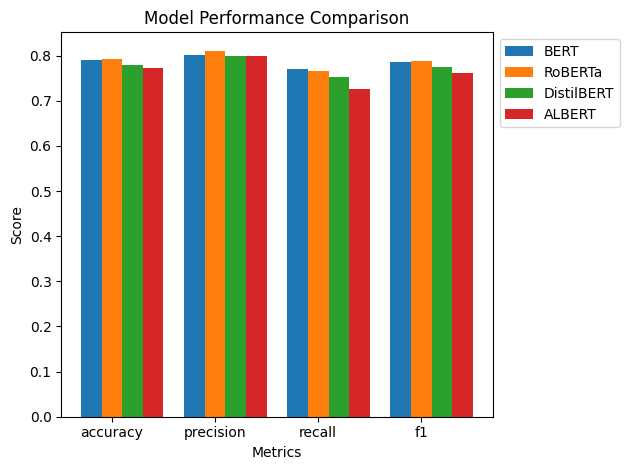

In [6]:
# Bar plot for accuracy, precision, recall, and F1 score
metrics = ['accuracy', 'precision', 'recall', 'f1']
x = np.arange(len(metrics))
width = 0.2
multiplier = 0

for model_name, result in results.items():
    offset = width * multiplier
    plt.bar(x + offset, [result[m] for m in metrics], width, label=model_name)
    multiplier += 1

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x + width, metrics)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

#### ROC Curves

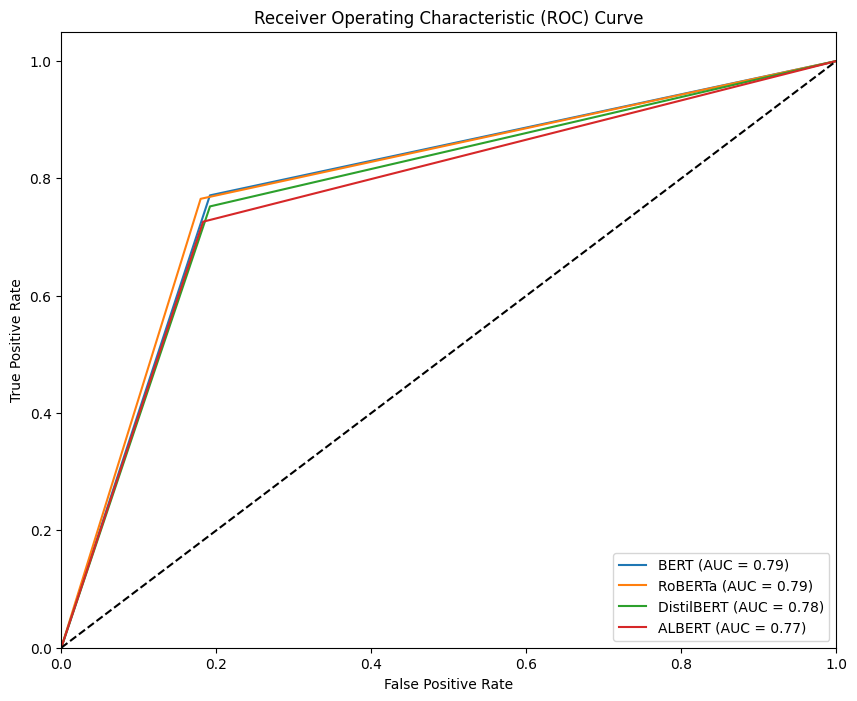


Results for BERT:
Accuracy: 0.7896
Precision: 0.8021
Recall: 0.7710
F1 Score: 0.7863
AUC: 0.7896

Results for RoBERTa:
Accuracy: 0.7926
Precision: 0.8109
Recall: 0.7652
F1 Score: 0.7874
AUC: 0.7927

Results for DistilBERT:
Accuracy: 0.7801
Precision: 0.7980
Recall: 0.7522
F1 Score: 0.7745
AUC: 0.7802

Results for ALBERT:
Accuracy: 0.7714
Precision: 0.8000
Recall: 0.7262
F1 Score: 0.7613
AUC: 0.7716


In [7]:
# ROC curves
plt.figure(figsize=(10, 8))

for model_name, result in results.items():
    plt.plot(result['fpr'], result['tpr'], label=f'{model_name} (AUC = {result["auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print detailed results
for model_name, result in results.items():
    print(f"\nResults for {model_name}:")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1 Score: {result['f1']:.4f}")
    print(f"AUC: {result['auc']:.4f}")

# Part 2 - Sentiment analysis on sarcasm

In [ ]:
import kaggle
import os
from groq import Groq
import zipfile
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import traceback
from tqdm import tqdm
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from dotenv import load_dotenv
import torch_directml
import emoji
from concurrent.futures import ProcessPoolExecutor, as_completed
from functools import partial
from joblib import Parallel, delayed
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Initialize DirectML device
device = torch_directml.device()

def download_kaggle_dataset(dataset, path):
    kaggle.api.dataset_download_files(dataset, path=path, unzip=True)

# Specify the dataset to download
dataset = "danofer/sarcasm"

# Specify the directory to save the dataset
save_dir = "./datasets/"

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Download the dataset
print(f"Downloading {dataset}...")
download_kaggle_dataset(dataset, save_dir)

print("Download completed!")

# List the files in the directory
print("\nFile scaricati:")
for file in os.listdir(save_dir):
    print(f"- {file}")

In [ ]:
try:
    import torch_directml
    device = torch_directml.device()
    print("Using DirectML")
except ImportError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"DirectML not available, using {device}")

#### Preprocessing

(Same as Dataset Cleaning at the beginning of the notebook)

In [ ]:
import os
import pandas as pd
import re
import emoji
from collections import Counter

df_file = os.path.join("datasets", "train-balanced-sarcasm.csv")

# Cleaning function
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = re.sub(r'http\S+', '', text)  # Rimuove URL
    text = re.sub(r'@\w+', '', text)  # Rimuove menzioni
    text = re.sub(r'#\w+', '', text)  # Rimuove hashtag
    text = re.sub(r'\d+', '', text)  # Rimuove numeri
    text = re.sub(r'[^\w\s]', '', text)  # Rimuove punteggiatura
    return text.lower().strip()

# Verify if a text is valid
def is_valid_text(text):
    # Rimuove emoji
    text = emoji.replace_emoji(text, '')
    # Rimuove spazi extra
    text = re.sub(r'\s+', ' ', text).strip()
    # Verifica se il testo ha almeno 3 parole e più di 10 caratteri
    words = text.split()
    
    # Verifica se ci sono parole ripetute più di 5 volte
    word_counts = Counter(words)
    if any(count > 5 for count in word_counts.values()):
        return False
    
    return len(words) >= 3 and len(text) > 10 and not text.isnumeric()

# Load the dataset
print("Loading data...")
df = pd.read_csv(df_file)
df = df[["label", "comment"]]

# Cleaning the dataset
print("Cleaning data...")
df['cleaned_comment'] = df['comment'].apply(clean_text)
df['is_valid'] = df['cleaned_comment'].apply(is_valid_text)
df = df[df['is_valid']]
df = df.drop('is_valid', axis=1)
df['comment'] = df['comment'].astype(str)

# Sampling the dataset
sample = 200000
df = df.head(sample)

print("Dataset pulito e filtrato. Dimensioni del nuovo DataFrame:", df.shape)
print("\nPrime 5 righe del DataFrame pulito:")
print(df.head())

In [ ]:
# Upload pre-trained models and tokenizers
print("Caricamento dei modelli e dei tokenizer...")
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(model_name1).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name1)

# Create pipeline for sentiment analysis
sentiment_pipeline = pipeline("sentiment-analysis", model=model1, tokenizer=tokenizer1, device=device)

In [ ]:
import pandas as pd
from tqdm import tqdm

# Truncate text to a maximum length
def truncate_text(text, max_length=512):
    words = text.split()
    if len(words) > max_length:
        return " ".join(words[:max_length])
    return text

# Analyzing sentiment of a text
def analyze_sentiment(text):
    try:
        truncated_text = truncate_text(text)
        result = sentiment_pipeline(truncated_text)[0]
        label = result['label']
        if label == 'LABEL_0':
            return 'Negative'
        elif label == 'LABEL_1':
            return 'Neutral'
        else:
            return 'Positive'
    except Exception as e:
        print(f"Error encountered in the text sentiment analysis: {text[:50]}...")
        print(f"Error: {str(e)}")
        return "Error"

# Function for processing the DataFrame
def process_dataframe(df):
    tqdm.pandas()
    
    # Analizza il sentiment
    df['sentiment'] = df['cleaned_comment'].progress_apply(analyze_sentiment)
    
    return df

# Process the DataFrame
print("Analisi del sentiment in corso...")
df_processed = process_dataframe(df)

# Sentiment distribution
print("\nSentiment Distribution:")
print(df_processed['sentiment'].value_counts())

# Examples
print("\nSome examples:")
sample_size = min(10, len(df_processed))
for _, row in df_processed.sample(sample_size).iterrows():
    print(f"Original comment: {row['comment'][:100]}...")
    print(f"Cleaned comment: {row['cleaned_comment'][:100]}...")
    print(f"Sentiment: {row['sentiment']}")
    print(f"Sarcasm: {'Sì' if row['label'] == 1 else 'No'}\n")

# Save the results
output_file = 'df_with_sentiment.csv'
df_processed.to_csv(output_file, index=False)
print(f"\nDataset with sentiment analysis saved in {output_file}")

# Final stats
print(f"\nTotal rows: {len(df_processed)}")
print(f"Sentiment distribution:")
print(df_processed['sentiment'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

In [ ]:
# Ensure the 'graphs' folder exists
os.makedirs('graphs', exist_ok=True)

# Load the dataset
df = pd.read_csv(os.path.join("datasets", "df_with_sentiment.csv"))

# Function to create and save word clouds
def create_wordcloud(text, title, filename):
    wordcloud = WordCloud(width=1600, height=800, 
                          background_color='white', 
                          colormap='viridis', 
                          contour_width=3, 
                          contour_color='steelblue').generate(text)
    
    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=24, pad=20)
    plt.tight_layout(pad=0)
    plt.savefig(os.path.join('graphs', filename), dpi=300, bbox_inches='tight')
    plt.close()

# Word clouds for sarcasm
create_wordcloud(' '.join(df[df['label'] == 1]['comment']), 'Common Words in Sarcastic Comments', 'sarcastic_wordcloud.png')
create_wordcloud(' '.join(df[df['label'] == 0]['comment']), 'Common Words in Non-Sarcastic Comments', 'non_sarcastic_wordcloud.png')

# Word clouds for sentiment
for sentiment in ['Positive', 'Neutral', 'Negative']:
    create_wordcloud(' '.join(df[df['sentiment'] == sentiment]['comment']), 
                     f'Common Words in {sentiment} Comments', 
                     f'{sentiment.lower()}_wordcloud.png')

# Correlation between sarcasm and sentiment
correlation = df['label'].corr(pd.get_dummies(df['sentiment'])['Positive'])
print(f"Correlation between sarcasm and positive sentiment: {correlation:.4f}")

# Visualize sentiment distribution for sarcastic and non-sarcastic comments
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.set_palette("deep")

ax = sns.countplot(data=df, x='sentiment', hue='label', 
                   hue_order=[0, 1],
                   order=['Positive', 'Neutral', 'Negative'])

plt.title('Sentiment Distribution for Sarcastic and Non-Sarcastic Comments', fontsize=16, pad=20)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Sarcasm', labels=['Non-Sarcastic', 'Sarcastic'], title_fontsize='13', fontsize='12')

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fontsize=10, padding=3)

plt.tight_layout()
plt.savefig(os.path.join('graphs', 'sentiment_distribution.png'), dpi=300, bbox_inches='tight')
plt.close()

print("All visualizations have been created and saved in the 'graphs' folder.")